In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **Loading dataset**

In [2]:
batch_size = 32
img_height = 224
img_width = 224

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'gdrive/MyDrive/Peltarion v1/dataset/train/Image', label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'gdrive/MyDrive/Peltarion v1/dataset/validation/Image', label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42
)

Found 1209 files belonging to 8 classes.
Found 303 files belonging to 8 classes.


## Show the data

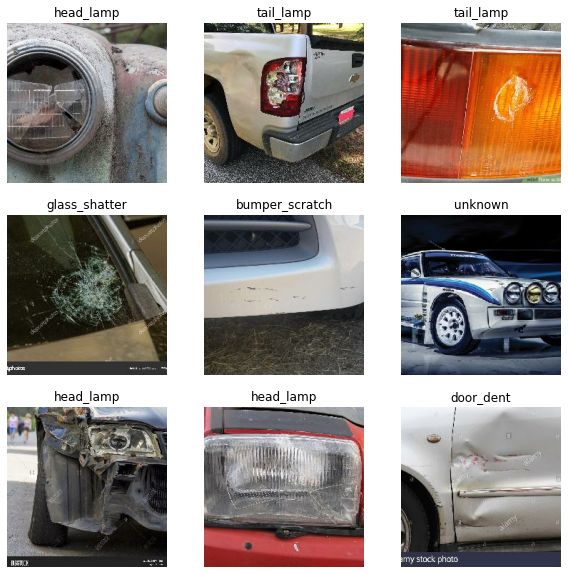

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  titles_str = ['bumper_dent','bumper_scratch','door_dent','door_scratch',
              'glass_shatter','head_lamp','tail_lamp','unknown']
  titles = tf.argmax(labels, axis=1).numpy().tolist()

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(titles_str[titles[i]])
    plt.axis("off")

## Configure the dataset for performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## **Model**

## Data augmentation layers

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

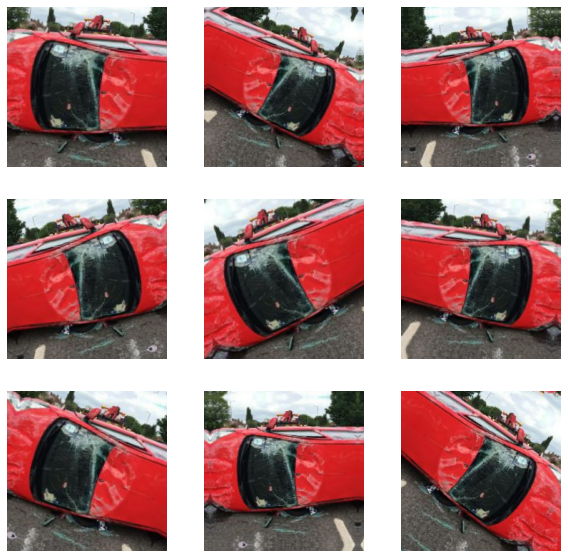

In [7]:
# show what data augmentation might look like
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model architecture

In [8]:
num_classes = len(titles_str)

# simple original
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.9),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)       

## Train

In [10]:
epochs = 200
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/200
38/38 [==============================] - 7s 86ms/step - loss: 1.9926 - accuracy: 0.3383 - val_loss: 2.4232 - val_accuracy: 0.3630
Epoch 2/200
38/38 [==============================] - 2s 49ms/step - loss: 1.8487 - accuracy: 0.3631 - val_loss: 1.9577 - val_accuracy: 0.3630
Epoch 3/200
38/38 [==============================] - 2s 49ms/step - loss: 1.7902 - accuracy: 0.3623 - val_loss: 1.8772 - val_accuracy: 0.3630
Epoch 4/200
38/38 [==============================] - 2s 53ms/step - loss: 1.7632 - accuracy: 0.3772 - val_loss: 1.7410 - val_accuracy: 0.3828
Epoch 5/200
38/38 [==============================] - 2s 49ms/step - loss: 1.7501 - accuracy: 0.3763 - val_loss: 2.0387 - val_accuracy: 0.3762
Epoch 6/200
38/38 [==============================] - 2s 49ms/step - loss: 1.7013 - accuracy: 0.3978 - val_loss: 1.6938 - val_accuracy: 0.3927
Epoch 7/200
38/38 [==============================] - 2s 48ms/step - loss: 1.7027 - accuracy: 0.4103 - val_loss: 1.7027 - val_accuracy: 0.3894
Epoch 

## Accuracy and loss graph

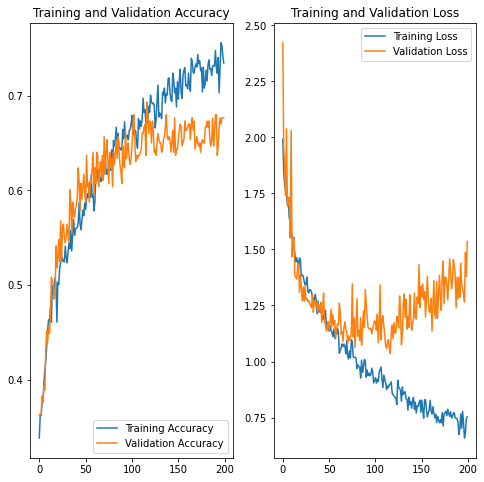

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()